<div style="direction:rtl;line-height:300%;"> <font face="XB Zar">
<div align=center>
    <div style="font-size:14px">
    به نام خدا
    </div><br>
    <strong><div style="font-size:50px; color: blue">
    ci - hw3
    </div></strong>
    <br>
    <div style="font-size:20px; color: #ff6600">
    مائده نادهی 9712762238
    </div>
</div>
<hr>

In [47]:
import math, time 
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import seaborn as sns
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip '/content/drive/MyDrive/MNIST dataset - train.zip'
!unzip '/content/drive/MyDrive/MNIST dataset - test.zip'

Archive:  /content/drive/MyDrive/MNIST dataset - train.zip
  inflating: train_label.csv         
  inflating: train_set.csv           
Archive:  /content/drive/MyDrive/MNIST dataset - test.zip
  inflating: test_label.csv          
  inflating: test_set.csv            


In [4]:
train_label = pd.read_csv("/content/train_label.csv")
train_label.rename(columns = {"5" : "actual_labels"}, inplace=True)
train_label = train_label["actual_labels"]
train_set = pd.read_csv("/content/train_set.csv")
train_set.set_axis([i for i in range(0,784)], axis=1, inplace=True)
test_set = pd.read_csv("/content/test_set.csv")
test_set.set_axis([i for i in range(0,784)], axis=1, inplace=True)
test_label = pd.read_csv("/content/test_label.csv")
test_label = test_label["7"]

<div id="section1" style="direction:rtl; font-size: 17px; font-family: 'XB Zar'; line-height: 200%">
<div style="font-size: 22px; color: #ff6600; font-weight: bold">
preprocessing
</div>
<hr>
<div>
ابتدا بررسی میکنیم داده ی غیر معتبر NULL و NAN نداشته باشیم :
</div>
</div>

In [48]:
# how many null?
print(test_set.isnull().sum().isnull().sum(axis = 0))
print(train_set.isnull().sum().isnull().sum(axis = 0))

0
0


In [49]:
con = train_set.std() > 0.4
xtrain2 = train_set.loc[:, con]
xtest2 = test_set.loc[:, con]
xtrain2.shape

(59999, 191)

<div id="section1" style="direction:rtl; font-size: 17px; font-family: 'XB Zar'; line-height: 200%">
<hr>
<div>
    از بخش کوچکی از داده ها (xtrain_small) 
    برای بررسی و یافتن بهترین هایپرپارامتر استفاده میکنیم (درغیر اینصورت زمان زیادی برای آموزش لازم است. با همین تعداد داده یک     ساعت اجرای
    ()grid.fit طول کشید.)
</div>
</div>

In [50]:
xtrain = train_set
ytrain = train_label
xtest = test_set
ytest = test_label
xtrain_small = xtrain[:3000]
ytrain_small = ytrain[:3000]

In [51]:
def eval_metrics(description, y_true, y_pred):
  print(description)
  print('Accuracy: {:.2f}'.format(metrics.accuracy_score(y_true, y_pred)))
  print('Rand Index: {:.2f}'.format(metrics.rand_score(y_true, y_pred)))
  print('------------------------')

<div id="section1" style="direction:rtl; font-size: 17px; font-family: 'XB Zar'; line-height: 200%">
<hr>
<div>
  در زیر تعداد داده های هر کلاس را در کل دیتاست و xtrain_small بررسی میکنیم:
</div>
</div>

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


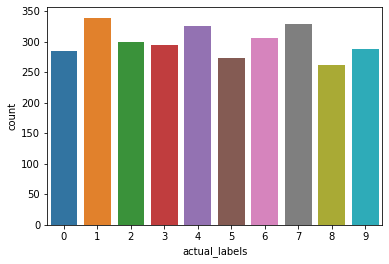

In [52]:
sns.countplot(ytrain_small)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


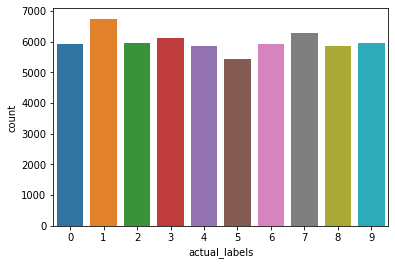

In [29]:
sns.countplot(ytrain)
plt.show()

<div id="section1" style="direction:rtl; font-size: 17px; font-family: 'XB Zar'; line-height: 200%">
<div>
  همانظور که مشاهده می شود داده ها به سمت عدد یک متمایل هستند و تعداد داده های با لیبل یک بیشتر از سایر داده هاست.
</div>
</div>
<hr>


<div id="section1" style="direction:rtl; font-size: 17px; font-family: 'XB Zar'; line-height: 200%">
<div>
   از پايپلاين براي اجراي پشت سر هم transformer(StandardScaler) و estimator(svm) استفاده میکنیم.
    به طوری که خروجی transformer ورودی estimator می باشد. 
    و مزیتی که نسبت که اجرای پشت سر هم بدون استفاده از پایپلاین دارد این است که اگر از پایپلابن استفاده نکنیم  StandardScaler  روی کل داده های ترین اجرا میشود همه ی 
   آنها را باهم میبیند و میانگین همه ی این داده ها حذف میکند بنابراین 
   K-Folds cross-validator  به درستی اجرا نخواهد شد.
    ولی اگر از پایپلاین استفاده شود 
 StandardScaler مستقلا روی k دسته ی fold
    (درینجا 5=k)
    به طور جداگانه اجرا میشود بنابراین K-Folds cross-validator 
    به درستی اجرا میشود.
</div>
</div>

In [53]:
steps = [('scaler', StandardScaler()), ('SVM', SVC())]
pipeline = Pipeline(steps) 

In [54]:
parameters = {'SVM__C':[0.001, 0.1, 100, 10e5], 'SVM__gamma':[10,1,0.1,0.01], 'SVM__degree': [2, 3, 4, 5], 'SVM__kernel': ['poly', 'rbf', 'linear', 'sigmoid']}
grid = GridSearchCV(pipeline, param_grid=parameters, cv=5) 

In [57]:
grid.fit(xtrain_small, ytrain_small)
print("score = ", grid.score(xtrain_small, ytrain_small)) 
print("best parameters from train data: ", grid.best_params_)

score =  0.9973333333333333
best parameters from train data:  {'SVM__C': 0.001, 'SVM__degree': 2, 'SVM__gamma': 0.1, 'SVM__kernel': 'poly'}


<div id="section1" style="direction:rtl; font-size: 17px; font-family: 'XB Zar'; line-height: 200%">
<div>
    بنابراین بهترین هایپرپارامتر های با accuracy برابر
    <span style="color: red">99درصد</span> 
   به قرار زیر است:
     <br>
    <ul style="margin-right: 0;">
    <li>پارامتر منظم سازی (C) - (اگر نویز دیتاست زیاد باشد باید C را کاهش دهیم تا منظم سازی بیشتر شود) : 0.001</li>
    <li>ضریب کرنل (gamma) : 0.1</li>
    <li>kernel : چندچمله ای</li>
    <li>درجه ی چند جمله ای (degree) : 2</li>
    </ul>
</div>
</div>
<hr>

C parameter : trades off misclassification of training examples against simplicity of the decision surface. A low C makes the decision surface smooth, while a high C aims at classifying all training examples correctly. 

In [58]:
y_pred = grid.predict(xtest)

In [59]:
eval_metrics("svm", ytest ,y_pred)

svm
Accuracy: 0.92
Rand Index: 0.97
------------------------


<div id="section1" style="direction:rtl; font-size: 17px; font-family: 'XB Zar'; line-height: 200%">
<div>
    مدل بدست آمده با استفاده از دیتاست کوچک روی داده های test دقتی برابر 92 درصد داد. 
</div>
</div>

<hr>
<div id="section1" style="direction:rtl; font-size: 17px; font-family: 'XB Zar'; line-height: 200%">
<div>
    حال با هایپرپارامتر های بدست آمده مدل خود را با کل دیتاست آموزش میدهیم:
</div>
</div>

In [61]:
 from sklearn.pipeline import make_pipeline

In [62]:
clf = make_pipeline(StandardScaler(), SVC(C=0.001, degree=2, gamma=0.1, kernel='poly'))
clf.fit(xtrain, ytrain)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=0.001, degree=2, gamma=0.1, kernel='poly'))])

In [64]:
y_pred = clf.predict(xtest)
eval_metrics("svm - whole dataset", ytest ,y_pred)

svm - whole dataset
Accuracy: 0.98
Rand Index: 0.99
------------------------


In [65]:
clf2 = make_pipeline(StandardScaler(), SVC(C=0.001, degree=3, gamma=10, kernel='poly'))
clf2.fit(xtrain, ytrain)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=0.001, gamma=10, kernel='poly'))])

In [66]:
y_pred = clf2.predict(xtest)
eval_metrics("svm - whole dataset", ytest ,y_pred)

svm - whole dataset
Accuracy: 0.98
Rand Index: 0.99
------------------------


<div id="section1" style="direction:rtl; font-size: 17px; font-family: 'XB Zar'; line-height: 200%">
<div>
    با آموزش دادن مدل توسط کل دیتاست همانطور که مشاهده میشود به accuracy برابر
    <span style="color: red">98درصد</span> 
    رسیدیم.
</div>
</div>
<hr>